# Fit a Gaussian profile to lines with MCMC

In the last notebook we explored the data through quantifying **line strengths** by eye.  In this notebook we will use a probabilistic computational technique called [Markov Chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) to fit a Gaussian to spectral lines in HPF data.  The area under the curve of the Gaussian will then represent the line strength.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
from astropy.io import fits
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set_context('paper')

In [2]:
goldilocks_files = glob.glob('../data/HPF/Helium-transit-data/**/Goldilocks*.fits', recursive=True)

In [3]:
def get_goldilocks_dataframe(fn):
    """Return a pandas Dataframe given a Goldilocks FITS file name"""
    hdus = fits.open(fn)
    df_original = pd.DataFrame()
    for j in range(28):
        df = pd.DataFrame()
        for i in range(1, 10):
            name = hdus[i].name
            df[name] = hdus[i].data[j, :]
        df['order'] = j
        df_original = df_original.append(df, ignore_index=True)
    keep_mask = df_original[df_original.columns[0:6]] != 0.0
    df_original = df_original[keep_mask.all(axis=1)].reset_index(drop=True)
    
    return df_original

In [4]:
index = 129 # Pick a number in the range (0,410]
fn = goldilocks_files[index]

In [5]:
%time df = get_goldilocks_dataframe(fn)

Wall time: 147 ms


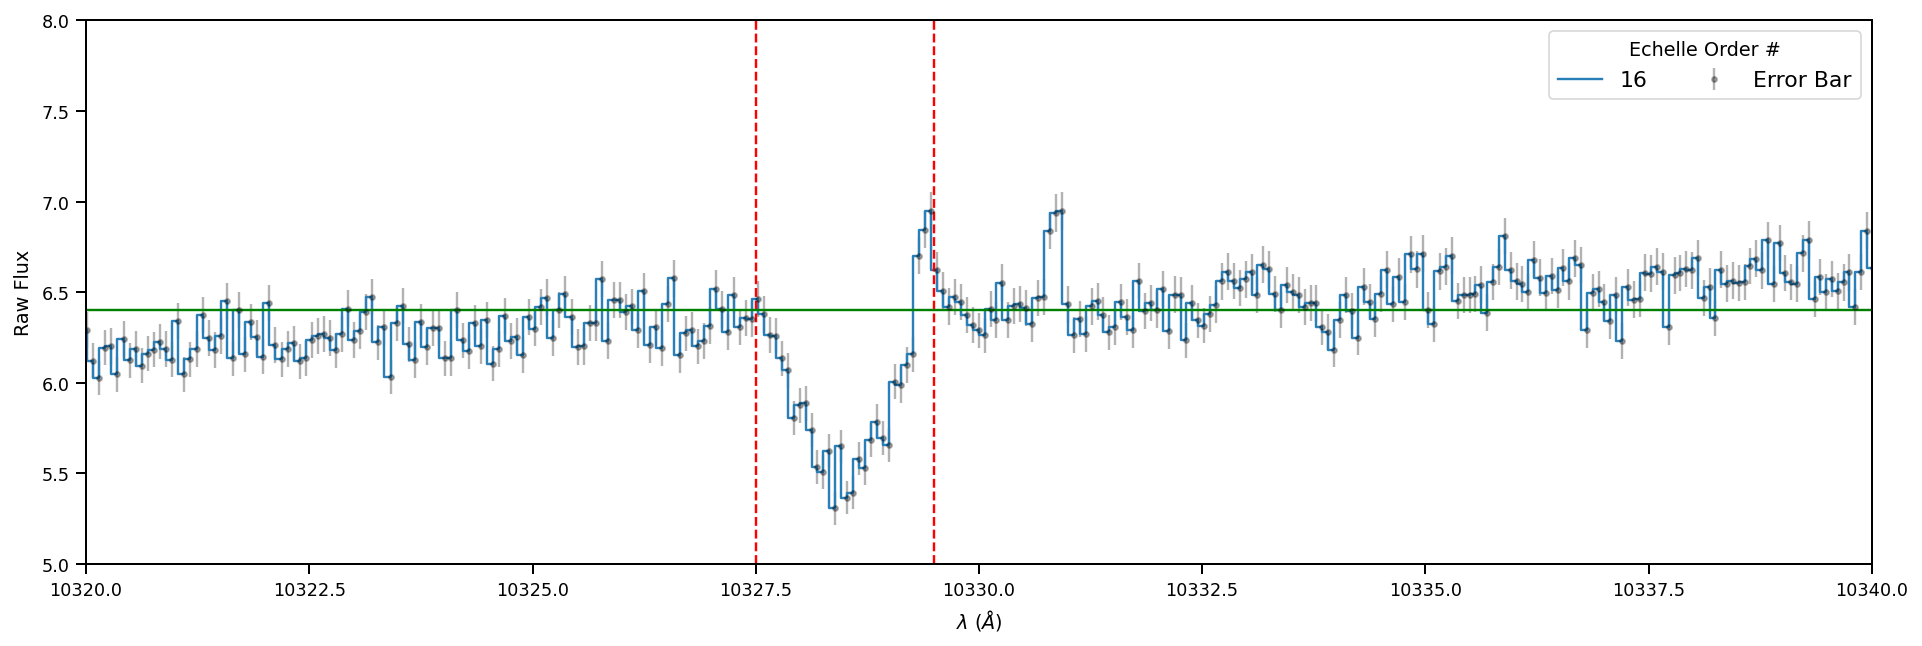

In [6]:
plt.figure(figsize=(16, 5))
order = 16
mask = df.order == order
plt.step(df['Sci Wavl'][mask], df['Sci Flux'][mask], label=order, color='#2980b9');
plt.errorbar(df['Sci Wavl'][mask], df['Sci Flux'][mask], df['Sci Error'][mask], fmt='.', c='k',
             label="Error Bar", alpha=0.3);
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.legend(ncol=7, title='Echelle Order #', fontsize=11);
plt.ylim(5,8)
plt.xlim(10320,10340)
wavelength1 = 10327.5
wavelength2 = 10329.5
plt.axvline(wavelength1,linestyle = 'dashed',color = 'red')
plt.axvline(wavelength2,linestyle = 'dashed',color = 'red')
plt.axhline(6.4,color = 'green')

Ok, let's fit a model to this data.  The model will consist of a straight-line trend with a Gaussian subtracted from it.  It will have five parameters, the straight-line trend slope $m$ and offset $b$, and the Gaussian amplitude $A$, center wavelength $\mu$, and width $w$.  
$$f_\lambda(m, b, A, \mu, w)= m \lambda +b - A\cdot e^{-\frac{1}{2} \frac{(\lambda-\mu)^2}{w^2}}$$

Let's focus on the **sub-region** set by the above plot.

In [7]:
sub_region = (df.order == order) & (df['Sci Wavl'] > 10320) & (df['Sci Wavl'] < 10340)
wl = df['Sci Wavl'][sub_region].values
flux = df['Sci Flux'][sub_region].values
unc = df['Sci Error'][sub_region].values

In [8]:
def generative_model(m, b, A, mu, w):
    """Generate the model given parameters"""
    continuum = m * (wl - 10330) + b
    gaussian = A * np.exp(-0.5*(wl-mu)**2/w**2)
    return continuum - gaussian

Let's make an initial guess.

In [9]:
m_guess, b_guess, A_guess, mu_guess, w_guess = 0.01, 6.4, 1.0, 10328.5, 0.4

In [10]:
flux_guess = generative_model(m_guess, b_guess, A_guess, mu_guess, w_guess)

(5.0, 8.0)

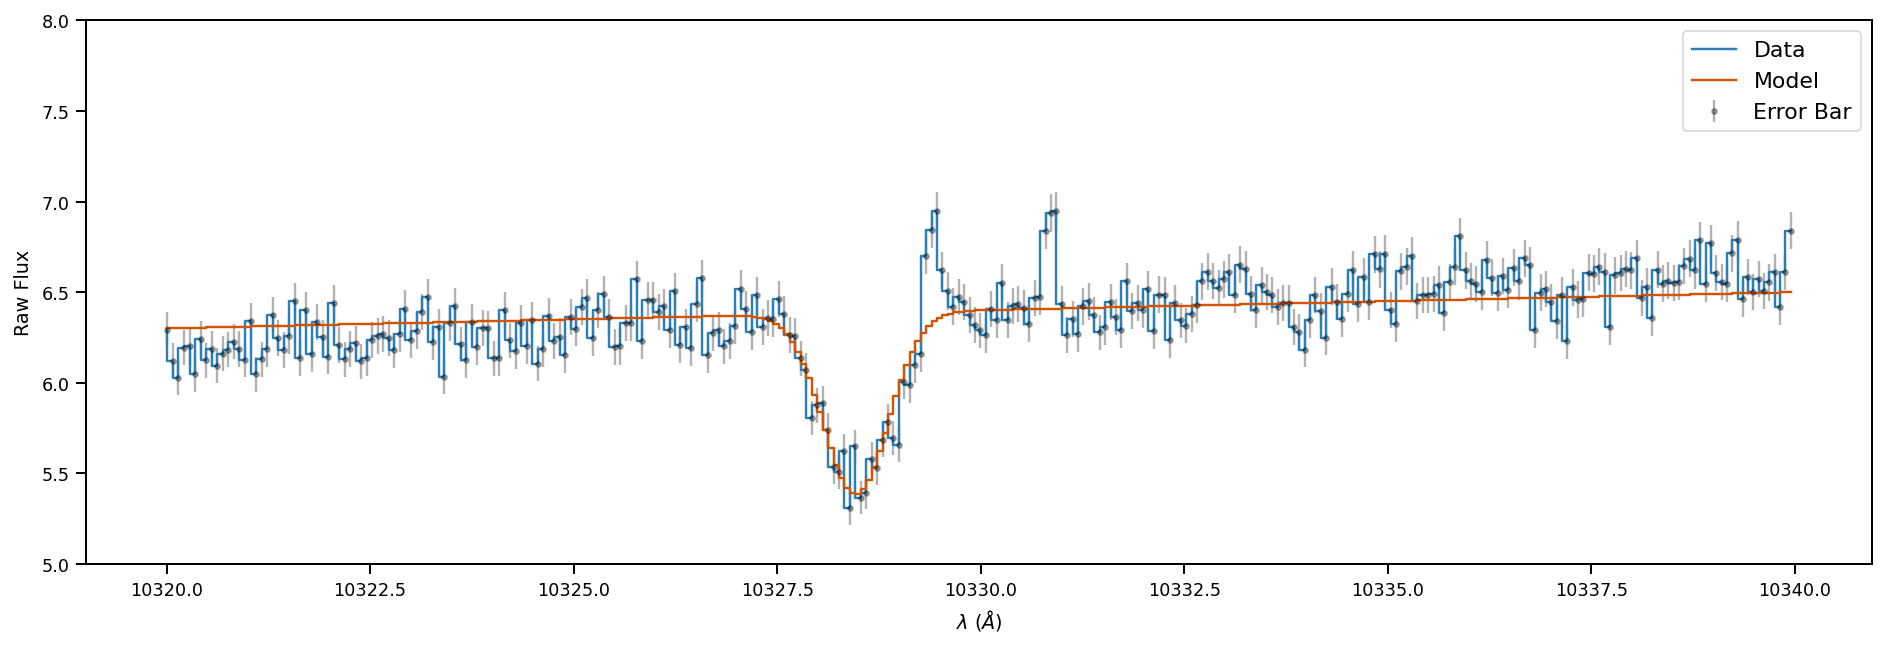

In [11]:
plt.figure(figsize=(16, 5))
plt.step(wl, flux, label='Data', color='#2980b9');
plt.errorbar(wl, flux, unc, fmt='.', c='k',label="Error Bar", alpha=0.3);
plt.step(wl, flux_guess, label='Model', color='#d35400');
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.legend(fontsize=11);
plt.ylim(5,8)

The guess is *close* but not perfect-- the line center is slightly off.  That's OK!  Let's use MCMC to fine tune these parameters, and tell us the uncertainty in the parameter values.  We will use [emcee](https://emcee.readthedocs.io/en/stable/).

In [12]:
import emcee

We need to compute the log likelihood of the data, which takes in the parameters and returns a scalar "quality of fit metric".  Here we use *chi squared*, the sum of the squares of the residuals, weighted by their uncertainties.

In [13]:
def log_likelihood(theta):
    m, b, A, mu, w = theta
    model = generative_model(m, b, A, mu, w)
    residual = flux - model
    chi_squared = np.sum(residual** 2 / unc**2)
    return -0.5 * chi_squared

In [14]:
theta_guess = np.array([m_guess, b_guess, A_guess, mu_guess, w_guess])
log_likelihood(theta_guess)

-318.1528223248164

In [15]:
n_walkers = 32
n_params = 5

In [16]:
pos = theta_guess + 1e-4 * np.random.randn(n_walkers, n_params)

In [17]:
n_steps = 5000

In [18]:
sampler = emcee.EnsembleSampler(n_walkers, n_params, log_likelihood)
sampler.run_mcmc(pos, n_steps, progress=True);

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 768.62it/s]


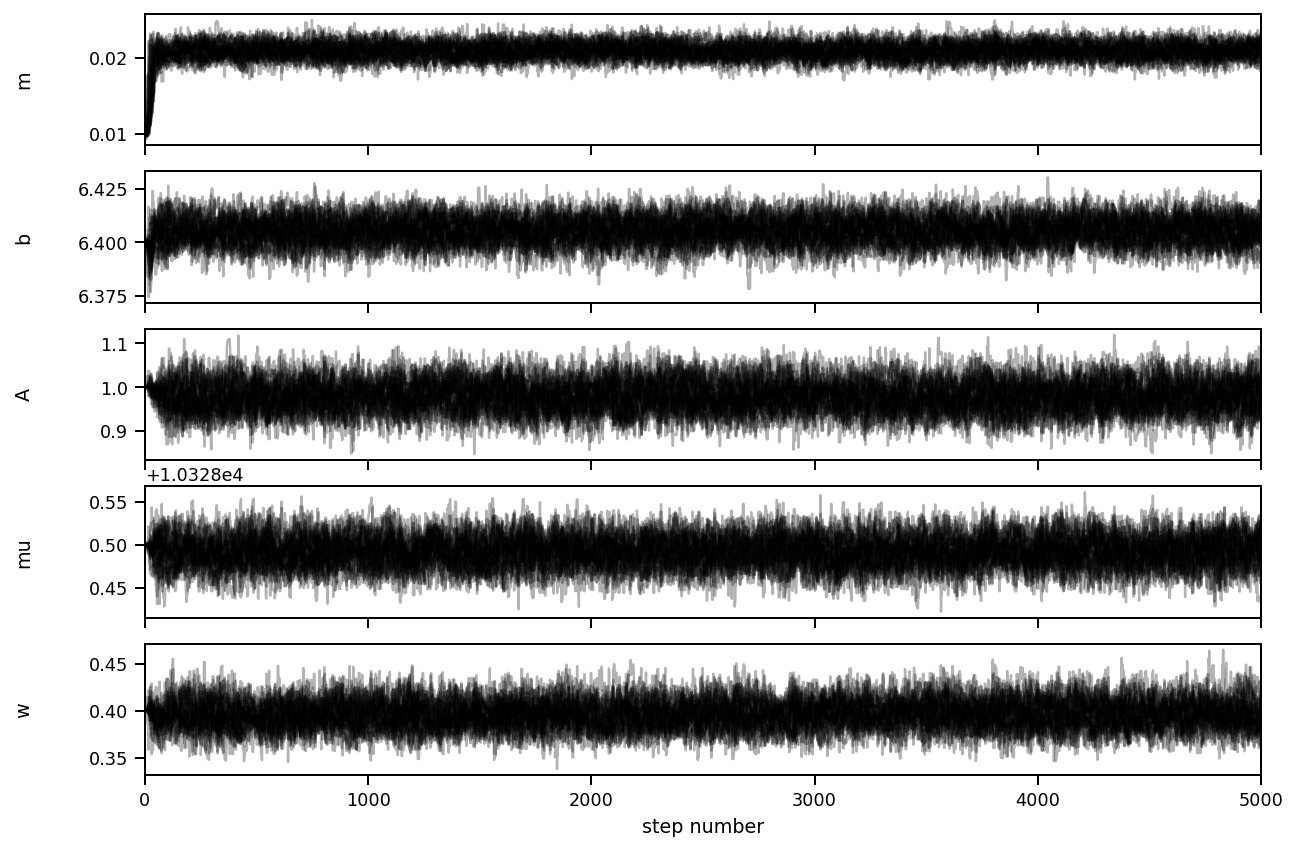

In [19]:
fig, axes = plt.subplots(n_params, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "A", "mu", "w"]
for i in range(n_params):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [20]:
A_draws = samples[2000:, :, 2].reshape(-1)

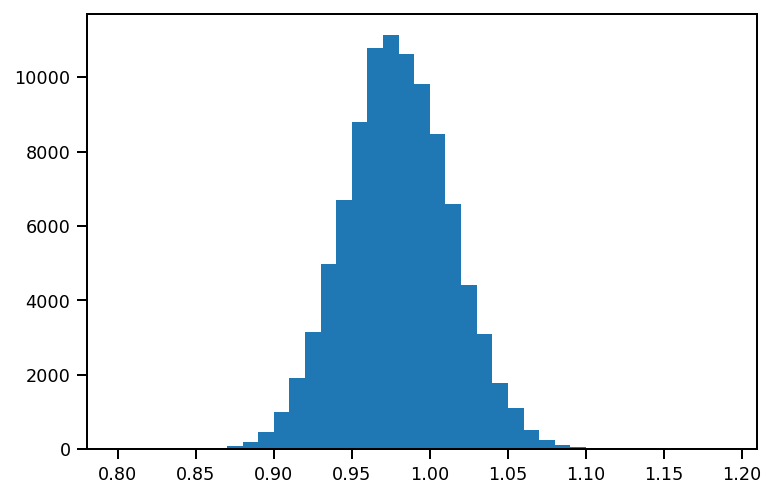

In [21]:
plt.hist(A_draws, bins = np.arange(0.8, 1.2, 0.01));

Let's make a "corner plot" that shows the distribution of parameters.  We can follow the demo on the [emcee tutorial](https://emcee.readthedocs.io/en/stable/tutorials/line/)

In [25]:
flat_samples = sampler.get_chain(discard=2000, thin=15, flat=True)

In [26]:
import corner

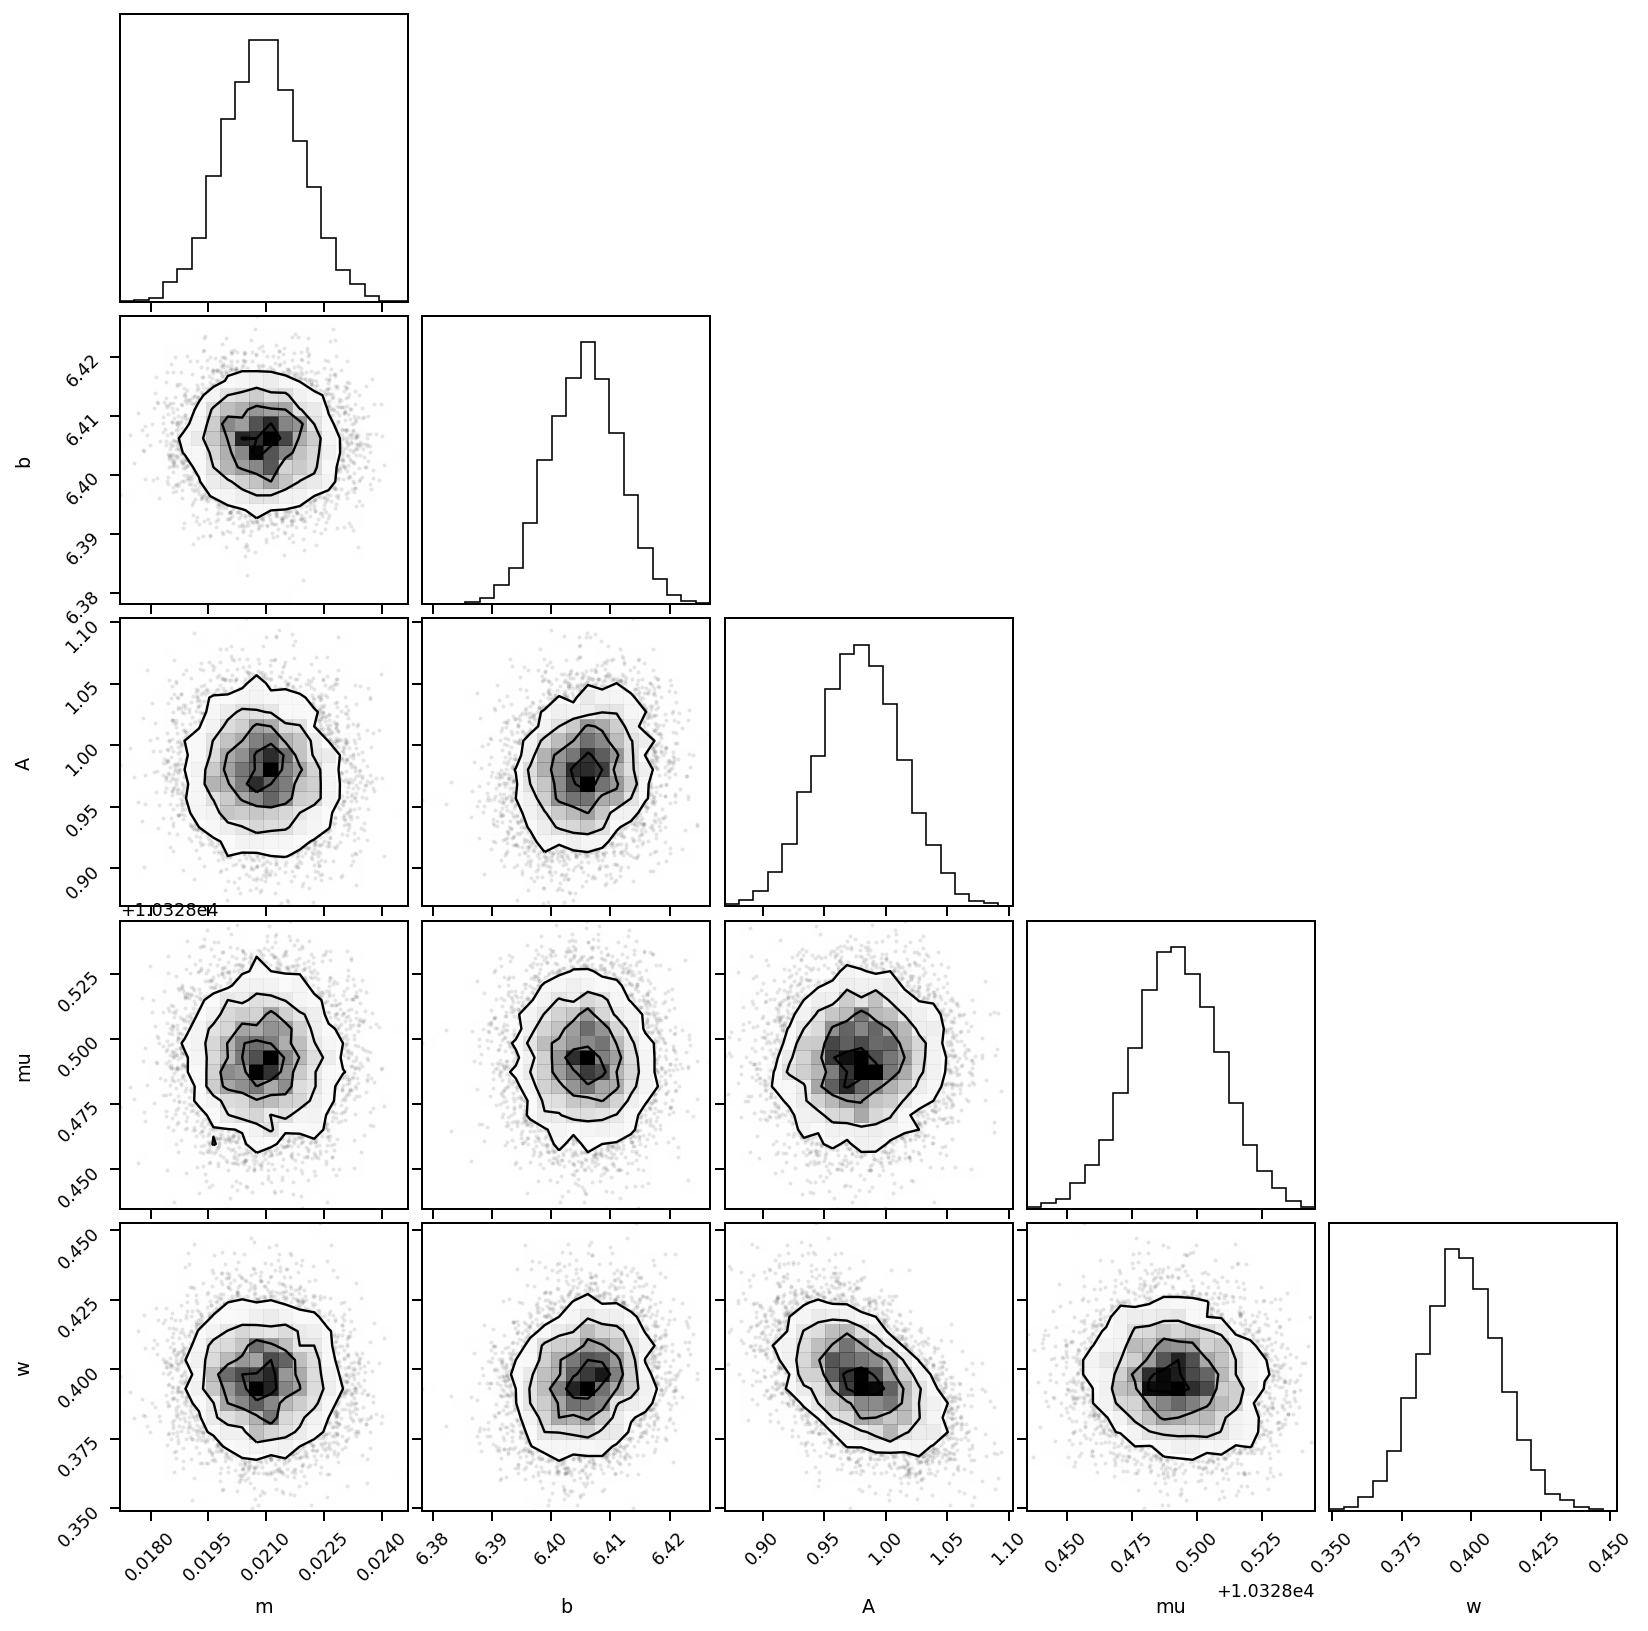

In [28]:
ax = corner.corner(flat_samples, labels=labels)

In [30]:
flat_samples.shape

(6400, 5)

In [35]:
m_fit, b_fit, A_fit, mu_fit, w_fit = flat_samples[3912, :]

In [36]:
good_fit = generative_model(m_fit, b_fit, A_fit, mu_fit, w_fit)

(5.0, 8.0)

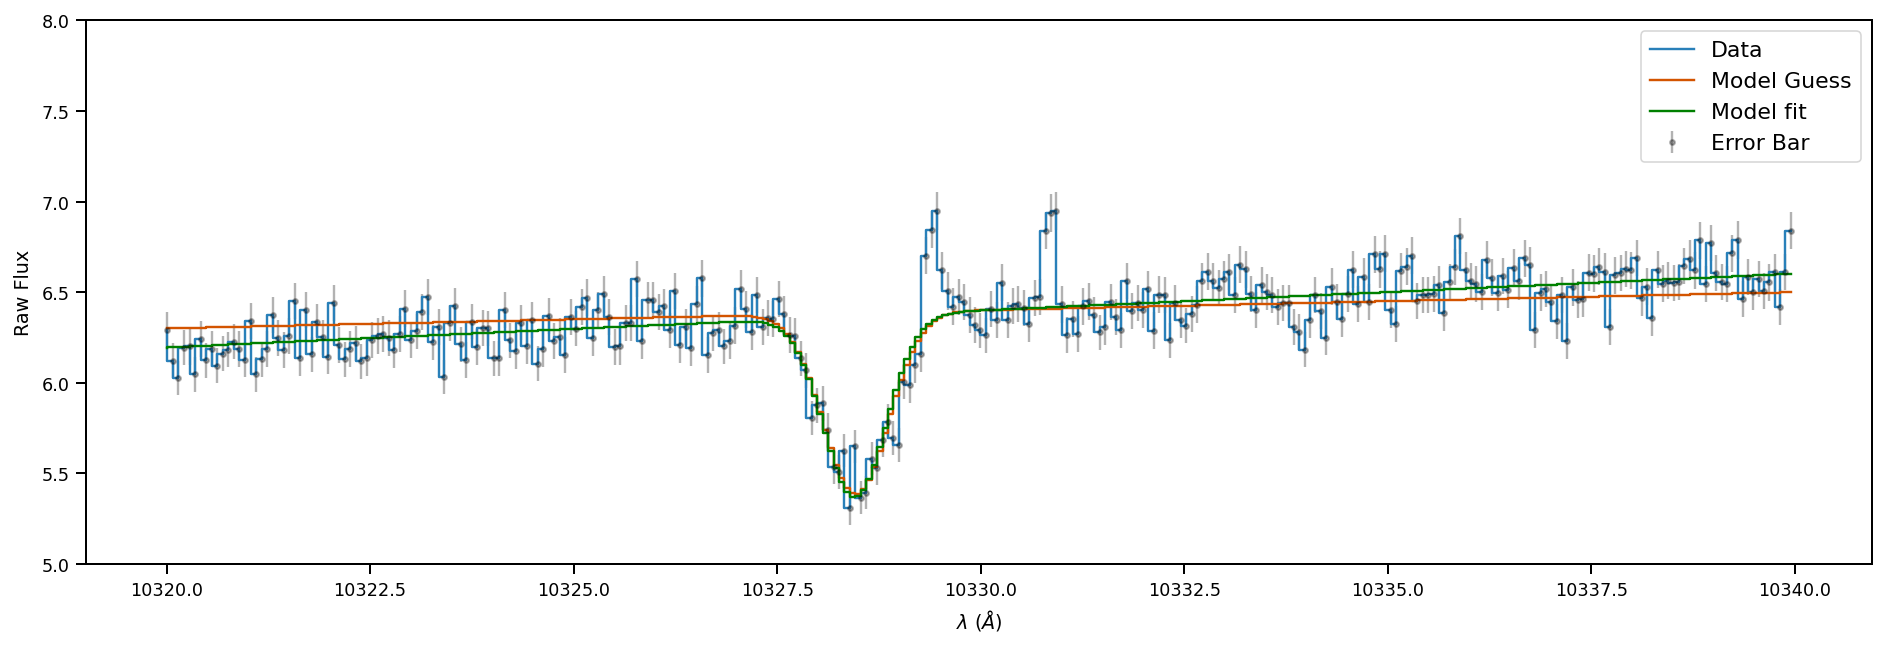

In [38]:
plt.figure(figsize=(16, 5))
plt.step(wl, flux, label='Data', color='#2980b9');
plt.errorbar(wl, flux, unc, fmt='.', c='k',label="Error Bar", alpha=0.3);
plt.step(wl, flux_guess, label='Model Guess', color='#d35400');
plt.step(wl, good_fit, label='Model fit', color='green');
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.legend(fontsize=11);
plt.ylim(5,8)